<a href="https://colab.research.google.com/github/Nickguild1993/Natural_language_processing/blob/main/HE_survey_text_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HUNTER'S EDUCATION TOPIC CLUSTERING

Using K-means to cluster responses around their respective centroids

Excellent holistic guide for colab functionality: https://www.tutorialspoint.com/google_colab/google_colab_quick_guide.htm

you'll need to set up your own api key, which you can do here: https://openai.com/api/

I put 5.00 down 6 months ago and have since run hundreds of calls and right now I'm at 4.58.

I use secrets manager to store my api key, here's a good resource on how to set that up: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0

You'll need to !pip install openAI the first time you use it. Once you've done that, you can comment it out.



#### installing libraries and connecting to gdrive and api

In [1]:
# import libraries

###### remember to pip install openai ####
# !pip install openai
##########################################

import pandas as pd
import numpy as np
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# model related
import openai
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os
# using Counter for assessing "no particular reason" count in X open ended response
from collections import Counter

# kmeans - that's the clustering model
#  t-SNE (t-distributed Stochastic Neighbor Embedding) is great visualizing high-dimensional data, like your text embeddings, in a 2D or 3D space. This allows you to visually inspect the quality of your clusters.

In [20]:
# summarization model libraries
import time
import re

In [2]:
# connect to gdrive

from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# call API key
openai.api_key = os.getenv("nick_open_ai")
##### you'll need to replace this your api key

In [ ]:
# the below code defines the ask format (that I've used for sentiment analysis, which will be later in the workflow but w/e).
# Can use it to verify the api key is connected, but the next cell with the try except error handling does the same thing!

# ################################################################################
# client = OpenAI(api_key = userdata.get('nick_open_ai')) # instantating client
#################################################################################


# completion = client.chat.completions.create( # completions is what chat returns and then creates that response based on the message/model
#     model="gpt-4o-mini",
#     messages=[
#         {"role": "system", "content": "You are a helpful subject matter expert in statistics and computer science."}, # sets the backgroun for gpt
#         {
#             "role": "user", # you're the user
#             "content": "Write a concise and accessible summary of what multimodal models are."
#         }
#     ]
# )

# print(completion.choices[0].message)

ChatCompletionMessage(content="Multimodal models are advanced artificial intelligence systems designed to process and analyze data from multiple types of modalities—such as text, images, audio, and video—simultaneously. These models leverage the strengths of each modality to enhance understanding and generate more comprehensive insights.\n\nFor instance, a multimodal model could analyze a video by interpreting the visual content alongside any spoken dialogue, allowing it to generate more accurate descriptions or respond to queries about the video's content. By integrating various forms of information, multimodal models can improve tasks like image captioning, video analysis, and sentiment detection, making them more versatile and effective in real-world applications.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


In [4]:
# try except error handling to determine if API key is active
client = OpenAI(api_key = userdata.get('nick_open_ai')) # instantating client

try:
    # Create an OpenAI client instance
    # The client automatically uses the OPENAI_API_KEY environment variable if it's set
    client

    # Make a simple, low-cost API call to list models
    client.models.list()

    print("Success! Your OpenAI API key is connected and working.")

except openai.AuthenticationError as e:
    print("[] AuthenticationError: Your API key is incorrect or has expired.")
    print("[x]  Please check API key and make sure it's stored correctly.")
    # print(f"   Error details: {e}") # Uncomment for more details
except Exception as e:
    print(f" An error occurred: {e}")
    print("   This could be a network issue or a problem with the OpenAI service.")


Success! Your OpenAI API key is connected and working.


###### reading in the excel file as the dataframe and cleaning it

In [5]:
# read in dataframe

df = pd.read_csv('/content/drive/MyDrive/Text_mining_projects/HE_survey/text_responses_artifiact_csv_removing.csv')
df.head(5)

,ASSIGNED_ID,Date Started,THE STRUCTURE OF THE HE PROGRAM SUPPORTS ME AS AN INSTRCTOR,THE TRAINING MATERIALS PROVIDED ARE OF HIGH QUALITY,THE TRAINING MATERIALS ARE USEFUL FOR INSTRUCTION,THE CURRICULUM PREPARES STUDENTS FOR REAL-WORLD HUNTING SAFETY AND RESPONSIBILITY,What aspects of the curriculum have the greatest impact (positive or negative) on student engagement during the course?,"In what ways, if any, could the curriculum better address the needs of students?",HANDOUTS_EFFECTIVE,VIDEOS_EFFECTIVE,...,What would help improve communication between the HE Program and volunteer instructors?,How likely would you be to use an online course or other web/app-based resource to conduct or enhance in-person HE classes?,What kind of digital resources would be most beneficial for instructors when preparing lessons for the Hunter Education course?,"If you could make one change to the Online Registration System, what would it be?",Do you have any suggestions for enhancing students' understanding of digital licenses within HE classes?,Are you a license sales agent for TPWD Hunting licenses?,What information or resources would improve the audience's understanding of using digital licenses?,How prepared do you feel as a sales agent to answer license buyers' questions regarding digital licenses?,Have you purchased a digital license?,Are there additional resources that you think would help make digital licenses more easily understood?
0,1,45828,Somewhat agree,Somewhat agree,Somewhat agree,Somewhat agree,Firearms safetyn,More information on real hunting experiences,Somewhat effective,Very effective,...,Training in regions no,Very Likely,Work shops not webinarsti of;Digital lesson pl...,NaN,NaN,No,NaN,NaN,No,NaN
1,2,45829,Strongly agree,Strongly agree,Strongly agree,Strongly agree,The pictures of people in the situation to be ...,Include information on all species as differen...,Somewhat effective,Somewhat effective,...,Shorter more to the point emails. Less news s...,Very Likely,Digital lesson plans and presentation slides;D...,Easier to search of find a class from the list...,NaN,No,NaN,NaN,Yes,More informational videos on social media and ...
2,3,45828,Strongly agree,Strongly agree,Strongly agree,Strongly agree,I think the material is great and very engagin...,No,Very effective,Very effective,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,45834,Strongly agree,Strongly agree,Strongly agree,Strongly agree,NaN,NaN,Very effective,Very effective,...,NaN,Unlikely,Video scenarios,NaN,NaN,No,NaN,NaN,No,NaN
4,5,45831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# renaming all the columns I'm going to analyze and then removing that annoying ass "_x000d_" which is an artifact from the excel import (line break thing)

# UPDATE: I reimported it as a .csv file, which mostly removes the issue.
df.rename(columns = {"In what ways, if any, could the curriculum better address the needs of students?" : "how_to_make_curriculum_better",
                     "What aspects of the curriculum have the greatest impact (positive or negative) on student engagement during the course?" : "impactful_engagement",
                     "How can the HE Program support you better?" : "HE_support",
                     "What topic(s) would you be interested in attending a workshop to learn more about?" : "workshop_topics",
                     "What would help improve communication between the HE Program and volunteer instructors?" : "improve_communication",
                     "If you could make one change to the Online Registration System, what would it be?" : "ORS_change",
                     "Do you have any suggestions for enhancing students' understanding of digital licenses within HE classes?" : "digital_license_info"
                     }, inplace= True)


In [62]:
# # okay, gotta use regex b/c the substrings are connected.

# # columns to iterate over

# columns_to_check = ['how_to_make_curriculum_better', 'impactful_engagement', 'HE_support', 'workshop_topics', 'improve_communication', 'ORS_change', 'digital_license_info']

# pattern_to_remove = r'_x000[Dd]_|\n|\r'

# for column in columns_to_check:
#   df[column] = df[column].str.replace(pattern_to_remove, '', regex=True)


In [7]:
#checking NaN counts by column
df.isna().sum()

,0
ASSIGNED_ID,0
Date Started,0
THE STRUCTURE OF THE HE PROGRAM SUPPORTS ME AS AN INSTRCTOR,20
THE TRAINING MATERIALS PROVIDED ARE OF HIGH QUALITY,21
THE TRAINING MATERIALS ARE USEFUL FOR INSTRUCTION,21
THE CURRICULUM PREPARES STUDENTS FOR REAL-WORLD HUNTING SAFETY AND RESPONSIBILITY,23
impactful_engagement,69
how_to_make_curriculum_better,94
HANDOUTS_EFFECTIVE,17
VIDEOS_EFFECTIVE,18


In [8]:
# count the number of rows for column that are less than 10 characters to see if it makes sense to pop em

print(df[df['impactful_engagement'].str.len() < 10].shape[0])
# print the responses to see if they should be thrown out
print(df[df['impactful_engagement'].str.len() < 10]['impactful_engagement'])
# Yeah, drop em

4
69          N/a
106    Hands on
132     Nothing
181        Book
Name: impactful_engagement, dtype: object


In [9]:
# name column as a variable

text_column = 'impactful_engagement'

# Drop rows where the text column is empty/NaN
df.dropna(subset=["impactful_engagement"], inplace=True)

# filter out short ass responses
df = df[df['impactful_engagement'].str.len() > 10]

# Create a list of the text to be embedded
texts_to_embed = df['impactful_engagement'].tolist()

print(f"Prepared {('impactful_engagement')} texts for embedding.")


Prepared impactful_engagement texts for embedding.


In [10]:
 ##################### CIRCLING BACK FROM CLUSTER INVESTIGATION ##############################################################################################
 ##########  IF THE RESPONDENT DIDN'T HAVE A RESPONSE, THEY WERE ASKED TO TYPE "NO PARTICULAR REASON"....THOSE RESPONSES SHOULDN'T BE A CLUSTER ##############
 #################### THEY SHOULD BE DROPPED BEFOREHAND ######################################################################################################

from collections import Counter


In [ ]:
 ##### REMOVING THE "NO SPECIFIC*** REASON" RESPONSES
 # b/c some folks used a "." at the end of that response, we need to use a "contains" method instead of a stricter "match" method

# df = df[~df['dirt_lizard_fave'].str.contains('No specific reason')]

# response_counts = Counter(df['dirt_lizard_fave'])

# sorted_counts = response_counts.most_common()

#########################################################################################
 ###  the below loop is commented out b/c the result is a very lengthly output  #########
 ########################################################################################


# for response, count in sorted_counts:
#   print(f'{response}: {count}')



Next, send this list of texts to OpenAI's embedding model. (as of 6/24) We will use text-embedding-3-small, which is OpenAI's latest embedding model. The result will be a list of vectors (lists of numbers), which we'll plug into the dataframe as a new column: "embeddings"

In [11]:
embedding_model = 'text-embedding-3-small' # best choice as of 6/24

# Create a list of the text to be embedded *after* dropping rows
texts_to_embed = df['impactful_engagement'].tolist()

# call the OpenAI embedding API, name response
response = client.embeddings.create(
    input = texts_to_embed,
    model = embedding_model
)

# Extract the embedding data from the response
embeddings = [data.embedding for data in response.data]

# add the embeddings to the df
df["embeddings"] = embeddings

print('Embeddings generated and appended onto the df')
# if you check the df here it'll look fucked, so check in the next cell if needed

Embeddings generated and appended onto the df


In [ ]:
# df.head(3)

###### using scikit-learn to cluster and analyze - elbow method :)

Running elbow method to find the optimal cluster count...


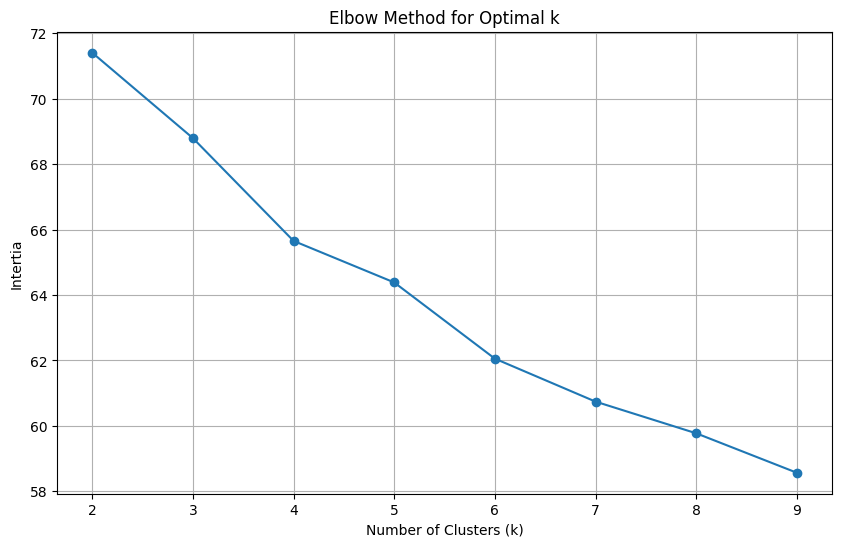

In [12]:
# convert the "embeddings" column to a format that scikit-learn can use
# which is, 2d numpy array with each row : embedding

# used X as variable name since its normally used to denote feature data in ML
X = np.array(df["embeddings"].tolist())

# elbow method, need to test clusters
k_range = range(2,10)
intertia_values = [] # create an empty list to store the score that K-means calculates for each value of "k". Holds results after loop

# check the cluster range to find the best
print('Running elbow method to find the optimal cluster count...')

for k in k_range:                                                               # n_init = 10 is the number of iterations to run from scratch and keep the best one out of those 10.
  kmeans = KMeans(n_clusters = k, init='k-means++', n_init=10, random_state = 13)       # FYI: 'k-means++' is a "smart" method for choosing initial cluster start points vis-a-vis RNG
  kmeans.fit(X)                                                                     # runs the K-means on the data (X). finds the best centroids for the "k" clusters and assigns the embeddings to their respective cluster. TRAINING
  intertia_values.append(kmeans.inertia_)                                         # score is "interia". this retrieves that score and appends it to the interia_values list
                                                            # additional info: interia is the metric for evaluating the elbow method. measures the sum of squared distances to their closest centroid.
                                                              #  i.e., how compact and internally coherent is a cluser- LOWER SCORE = BETTER
# plot the results
plt.figure(figsize = (10,6))
plt.plot(k_range, intertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Intertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

##### Apply the ideal (or assumed, at least) number of clusters to the kmeans.

###### update: 8/4 - 4 clusters are too few, testing more

In [13]:
# based on the elbow method chart, it looks like it's either 4 or 5 clusters

# set optimal_k
optimal_k = 4

# just in case, set the data as a numpy array (it's above but in case something changes in the code block)
X = np.array(df["embeddings"].tolist())

print(f'Running K-means w/ k = {optimal_k} clusters....')

# initialize the model with the # of clusters chosen
kmeans = KMeans(
    n_clusters = optimal_k,
    init = 'k-means++',
    n_init = 10,
    random_state = 13
)

# run it, boys
kmeans.fit(X)

# Assign da labels back to the DF
# FYI: .labels_ --> contains the cluster number that the row of text (customer response) is paired with
df['cluster'] = kmeans.labels_

print("inshallah alhamduliah, cluster mapping complete")

Running K-means w/ k = 4 clusters....
inshallah alhamduliah, cluster mapping complete


Checking the results of da clustering

In [34]:
# check the dataframe real quick
# df.head(3)

In [14]:
# ############################## CHECKING THE CLUSTER SIZES --> If we have 1 cluster with only a few attached responses, then that cluster might be unnecessary ####################

print(f"Distribution of responses amongst the {optimal_k} clusters is:")
print(df['cluster'].value_counts().sort_index())

Distribution of responses amongst the 4 clusters is:
cluster
0    27
1    33
2    34
3    16
Name: count, dtype: int64


In [15]:
print('Analyzing responses from each cluster')
for i in range(optimal_k):
  print(f"Cluster {i}  (size: {df[df['cluster'] == i].shape[0]})")
  sample_responses = df[df['cluster'] == i]['impactful_engagement'].head(5).tolist()
  for response in sample_responses:
    print(f' {response[:75]}...')

Analyzing responses from each cluster
Cluster 0  (size: 27)
 The books have the greatest impact over the slides in my opinion because th...
I refuse to do classroom....
Raul Rodriquez...
 Instructor should be able to provide real world experience and knowledge to...
 Positive aspects are when we have hands on items, firearm drills, zones of ...
Cluster 1  (size: 33)
 I think the material is great and very engaging. Easy to comprehend...
 I have never asked this question. The kids seem to absorb the entire progra...
 We use several videos that provide excellent examples of what is trying to ...
 need the PowerPoint to match up with booklets....
 The connection to conservation, the safety aspects - positive. The end of t...
Cluster 2  (size: 34)
 Firearms safetyn...
 The pictures of people in the situation to be able to help them imagine and...
 Handling of the inop firearms...
 Use the sections that are truly needed for hunting---for example the ''blac...
 Handling firearms. Safe carryi

##### LET'S TURN THOSE CONTEXTUALLY MEANINGLESS CLUSTER NUMBERS INTO KEYWORDS

In [16]:
# already established the column & the number of clusters so I don't need to rewrite that
text_column_name = 'impactful_engagement' # doing this so it's not hardcoded


In [17]:


def get_cluster_keyword(texts, model="gpt-4o"):
    """
    Uses OpenAI's Chat API to generate a single keyword for a list of texts.

    """
    # ---
    # Join all texts from the list.
    # ----
    combined_responses = "\n".join(texts)

    prompt = f"""
    Analyze the following survey responses texts to form topic clusters. The respondents are instructors who teach a course on hunter education.
    Your task is to provide a single, concise keyword or a 2-word phrase that best summarizes the respondent's answer.

    RULES:
    1.  Respond with the keyword/phrase ONLY.
    2.  Do not provide any explanation, preamble, or punctuation like quotes.
    3.  The keyword should be lowercase.
    4.  Respondents may have misspelled words. when possible, please interpret those answers to the best of your ability.
    5.  hunter education should not be a keyword, as it is the topic of the survey.

    --- THE TEXT TO BE EXAMINED ---
    {combined_responses}
    --- END OF TEXT TO BE EXAMINED ---

    Based on the rules, what is the single summary keyword or phrase?
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a subject matter expert in text analysis and survey design."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=10
        )
        keyword = response.choices[0].message.content.strip().replace('"', '')
        return keyword
    except Exception as e:
        # This is important for debugging if a cluster is too large for the openAI API
        print(f"GDI an error occurred: {e}")
        return "error"

# --- Main loop  ---

cluster_keywords = {}

print("Generating keywords for each cluster...")   # NOTE: THE OPTIMAL_K REFERS TO THE INTREPRETTED BEST NUMBER OF CLUSTERS FROM THE ELBOW PLOT
for i in range(optimal_k):
    # Get all responses belonging to the current cluster
    cluster_texts = df[df['cluster'] == i][text_column_name].tolist()

    if not cluster_texts:
        print(f"Cluster {i}: Skipping (no texts found)")
        continue

    # Generate the keyword using all responses in the cluster
    keyword = get_cluster_keyword(cluster_texts)

    cluster_keywords[i] = keyword
    print(f"Cluster {i}: {keyword}")

print("\n Yuhhhhhh keyword generation complete!")
print("Generated keywords:", cluster_keywords)

# --- Apply keywords back to the df ---
df['topic_keyword'] = df['cluster'].map(cluster_keywords)

print("\nDataFrame with final topic keywords:")
print(df[[text_column_name, 'cluster', 'topic_keyword']].head())

Generating keywords for each cluster...
Cluster 0: skills trail
Cluster 1: online courses
Cluster 2: firearm safety
Cluster 3: hands on

 Yuhhhhhh keyword generation complete!
Generated keywords: {0: 'skills trail', 1: 'online courses', 2: 'firearm safety', 3: 'hands on'}

DataFrame with final topic keywords:
                                impactful_engagement  cluster   topic_keyword
0                                   Firearms safetyn        2  firearm safety
1  The pictures of people in the situation to be ...        2  firearm safety
2  I think the material is great and very engagin...        1  online courses
6  I have never asked this question. The kids see...        1  online courses
7  We use several videos that provide excellent e...        1  online courses


In [18]:
df['topic_keyword']

,topic_keyword
0,firearm safety
1,firearm safety
2,online courses
6,online courses
7,online courses
...,...
177,online courses
179,hands on
180,online courses
182,firearm safety


In [19]:
# let's look at the responses within X cluster

# select all rows with topic_cluster = "close up"

topic_cluster_keyword = 'skills trail'

df_cluster_eval = df[df['topic_keyword'].str.contains(topic_cluster_keyword)]

df_cluster_eval[['impactful_engagement', 'topic_keyword']]

,impactful_engagement,topic_keyword
14,The books have the greatest impact over the sl...,skills trail
15,Field skills.\rI refuse to do classroom.,skills trail
33,"I'm not an instructor, How con I become one?\r...",skills trail
54,Instructor should be able to provide real worl...,skills trail
59,Positive aspects are when we have hands on ite...,skills trail
64,Skills trail (most effective).\r\rWell describ...,skills trail
74,Greatest impact: Training aids and some ''hand...,skills trail
76,Instructor experience related to the curriculum.,skills trail
83,The actual shooting and skills demonstration p...,skills trail
85,a skills trail in the feild is best and should...,skills trail


In [ ]:
# Now we need to take the responses of each respondent and summarize them.
# customer id: ASSIGNED_ID , cluster : cluster , topic_keyword

In [22]:
def generate_cluster_summary(cluster_responses: list, topic_keyword: str) -> str:
    """
    Generates a concise summary for a given cluster of text responses
    using the OpenAI GPT-4o model, incorporating a provided keyword.

    Args:
        cluster_responses (list): A list of strings, where each string is a response
                                  belonging to the current cluster.
        topic_keyword (str): The pre-assigned keyword for this cluster.

    Returns:
        str: A concise summary of the cluster's main theme.
    """
    # Join responses for the prompt, ensuring it fits within context window
    # Limit to a reasonable number of responses or characters if clusters are very large
    # Taking up to 20 responses for the prompt to keep it manageable for LLM context.
    responses_for_llm = "\n".join(cluster_responses[:40]) # the largest response segment is 36, I think

    # Construct the prompt for the LLM
    # Define the system role, rules, and user content clearly.
    messages = [
        {"role": "system", "content": (
            "You are a highly analytical and concise assistant. "
            "Your task is to summarize customer feedback. "
            "Focus on the main sentiment and recurring themes. "
            "Keep the summary brief and to the point, referencing the provided keyword."
        )},
        {"role": "user", "content": (
            f"Given the keyword '{topic_keyword}', summarize the main theme "
            "and sentiment of the following customer responses. "
            "Do not include the keyword in the summary itself. "
            "The summary should be no more than 3-4 sentences.\n\n"
            f"Responses:\n{responses_for_llm}"
        )}
    ]

    # Exponential backoff for API calls
    retries = 0
    max_retries = 5
    base_delay = 1 # seconds

    while retries < max_retries:
        try:
            chat_completion = client.chat.completions.create(
                model="gpt-4o", # Using gpt-4o for better summarization
                messages=messages,
                max_tokens=150 # Limit summary length to ensure conciseness
            )
            summary = chat_completion.choices[0].message.content.strip()
            return summary # Return summary on success
        except Exception as e:
            retries += 1
            delay = base_delay * (2 ** retries) # Exponential backoff
            print(f"Error calling OpenAI API for keyword '{topic_keyword}'. Retrying in {delay}s... (Attempt {retries}/{max_retries}) Error: {e}")
            time.sleep(delay)
    print(f"Failed to get summary for keyword '{topic_keyword}' after {max_retries} retries.")
    return "Failed to generate summary." # Return failure message after all retries

# --- 3. Generate Summaries for Each Cluster ---

cluster_analysis_results = {}

print("--- Generating Summaries for Each Cluster ---")

# Get unique clusters and their associated keyword
# Assuming 'topic_keyword' is consistent within each cluster.
# If not, you might need to decide how to pick a representative keyword per cluster.
unique_clusters_keywords = df[['cluster', 'topic_keyword']].drop_duplicates().set_index('cluster')['topic_keyword'].to_dict()

for cluster_id, topic_keyword in unique_clusters_keywords.items():
    cluster_responses = df[df['cluster'] == cluster_id]['impactful_engagement'].tolist()

    # Call the function to get the summary
    cluster_summary = generate_cluster_summary(cluster_responses, topic_keyword)

    cluster_analysis_results[cluster_id] = {
        'keyword': topic_keyword,
        'summary': cluster_summary,
        'sample_responses': cluster_responses # Keep original responses for review
    }
    print(f"Cluster {cluster_id} (Keyword: '{topic_keyword}'): Summary='{cluster_summary}'")
    print("-" * 30)


print("\n--- Final Cluster Analysis Results ---")
for cluster_id, info in cluster_analysis_results.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Keyword: {info['keyword']}")
    print(f"  Summary: {info['summary']}")
    print("  Sample Responses:")
    for i, resp in enumerate(info['sample_responses'][:3]): # Show first 3 responses
        print(f"    - {resp}")
    if len(info['sample_responses']) > 3:
        print(f"    ... ({len(info['sample_responses']) - 3} more responses)")

--- Generating Summaries for Each Cluster ---
Cluster 2 (Keyword: 'firearm safety'): Summary='The feedback reflects a strong positive sentiment towards the emphasis on safe practices and continuous education in the training program. Recurring themes include the importance of hands-on experiences and video demonstrations to effectively convey safety and ethical behavior. Concerns are noted regarding outdated instructional videos and materials, suggesting a need for updates to maintain engagement. Overall, safety is perceived as the most critical component, with supplementary focus on ethics, legal guidelines, and responsible use.'
------------------------------
Cluster 1 (Keyword: 'online courses'): Summary='The feedback reveals a mixed sentiment about the structure and delivery. Positive aspects include engaging material, effective visual aids like videos and PowerPoint presentations, and comprehensive manual references. However, recurring concerns emerge about insufficient integration

In [24]:
# Create a list of dictionaries from the cluster_analysis_results
data = []
for cluster_id, info in cluster_analysis_results.items():
    data.append({
        'Cluster ID': cluster_id,
        'Keyword': info['keyword'],
        'Summary': info['summary'],
        'Number of Responses': len(info['sample_responses'])
    })

# Create a DataFrame
cluster_summary_df = pd.DataFrame(data)

# Display the DataFrame
display(cluster_summary_df)

,Cluster ID,Keyword,Summary,Number of Responses
0,2,firearm safety,The feedback reflects a strong positive sentim...,34
1,1,online courses,The feedback reveals a mixed sentiment about t...,33
2,0,skills trail,The main sentiment of the feedback is positive...,27
3,3,hands on,The main sentiment of the feedback is overwhel...,16


In [26]:
# removing column width limit to print the entire summaries
pd.set_option('display.max_colwidth', None)

print(cluster_summary_df['Summary'])

0                                                                        The feedback reflects a strong positive sentiment towards the emphasis on safe practices and continuous education in the training program. Recurring themes include the importance of hands-on experiences and video demonstrations to effectively convey safety and ethical behavior. Concerns are noted regarding outdated instructional videos and materials, suggesting a need for updates to maintain engagement. Overall, safety is perceived as the most critical component, with supplementary focus on ethics, legal guidelines, and responsible use.
1                                                                    The feedback reveals a mixed sentiment about the structure and delivery. Positive aspects include engaging material, effective visual aids like videos and PowerPoint presentations, and comprehensive manual references. However, recurring concerns emerge about insufficient integration with hands-on activities, overl

In [32]:
# replace "customer" with "instructor" for each summary
words_to_replace = ['customer', 'Customer']
replacement_word = 'instructor'

for word in words_to_replace:
    cluster_summary_df['Summary'] = cluster_summary_df['Summary'].str.replace(word, replacement_word)

In [33]:
# in retrospect...should've just lowercased all words so "customer" caught all instances
cluster_summary_df['Summary']

,Summary
0,"The feedback reflects a strong positive sentiment towards the emphasis on safe practices and continuous education in the training program. Recurring themes include the importance of hands-on experiences and video demonstrations to effectively convey safety and ethical behavior. Concerns are noted regarding outdated instructional videos and materials, suggesting a need for updates to maintain engagement. Overall, safety is perceived as the most critical component, with supplementary focus on ethics, legal guidelines, and responsible use."
1,"The feedback reveals a mixed sentiment about the structure and delivery. Positive aspects include engaging material, effective visual aids like videos and PowerPoint presentations, and comprehensive manual references. However, recurring concerns emerge about insufficient integration with hands-on activities, overly simplified content, and potential issues with accountability and authenticity in quizzes and tests. There's a general preference for more interactive, classroom-based learning to enhance understanding, particularly for beginners."
2,"The main sentiment of the feedback is positive towards hands-on learning through practical activities. instructors emphasize that such activities, particularly those involving tangible training aids and real-world scenarios, significantly enhance student engagement and learning retention. Conversely, traditional classroom activities like lectures or slide shows are seen as less effective. There is a strong call for more training aids and resources to support these practical exercises, with an emphasis on the importance of experienced instructors who are able to facilitate dynamic and engaging experiences."
3,"The main sentiment of the feedback is overwhelmingly positive towards interactive methods. instructors frequently highlight that hands-on activities enhance engagement, participation, and attentiveness among students. There is a strong preference for classes incorporating these approaches, as they significantly impact student interest and involvement positively."


In [37]:
# export the cluster_summary_df as an excel document

# b/c we'll have multiple cluster_summaries, need to explicitly indicate the questions each summary relates to

impactful_engagement_cluster_summary_df = cluster_summary_df
impactful_engagement_cluster_summary_df.to_excel('impactful_engagement_cluster_summary.xlsx', index=False)